<a href="https://colab.research.google.com/github/gauriagarwal18/NYC-Taxi-Trip-Time-Prediction/blob/master/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

##Data Loading And Description

###We are using the following libraries for analysis:
- Numpy: We will use numpy arrays as they are comparitively faster than lists, also columns of dataframes behaves as numpy arrays

- Pandas: for reading the data from csv file, for data clening and for preparing data for analysis

- matplotlib,seaborn: for different visualisations, for drawing conclusions from data and for exploratory data analysis. 

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

###Data Loading
Loading CSV file from google drive in colab enviroment:
We will first load our csv file in which data is stored to the colab enviroment in data frame format so that we can make the copy of the original data and perform the required cleaning and analysis on that data without changing the original one.



In [ ]:
#Download datasets Hepatitis automobile from UCI repository
from google.colab import drive
drive.mount('/content/drive')
import os
path="/content/drive/My Drive/AlmaBetter_Capstone_projects/Capstone_project2_ml/NYC_TaxiData.csv"
taxi_original=pd.read_csv(path,parse_dates=[2,3])
taxi= taxi_original.copy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Data Description

In [ ]:
#shape of the data
taxi.shape

(1458644, 11)

In [ ]:
taxi.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435




The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

<b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


<b>Data fields</b>
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [ ]:
taxi.info()
"""
here we note that there is not any null value in data right now,
we have two date-time columns
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


'\nhere we note that there is not any null value in data right now,\nwe have two date-time columns\n'

In [ ]:
taxi.describe(include="all")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
count,1458644,1.458644e+06,1458644,1458644,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1458644,1.458644e+06
unique,1458644,NaN,1380222,1380377,NaN,NaN,NaN,NaN,NaN,2,NaN
top,id2875421,NaN,2016-03-04 08:07:34,2016-02-19 19:25:04,NaN,NaN,NaN,NaN,NaN,N,NaN
freq,1,NaN,5,5,NaN,NaN,NaN,NaN,NaN,1450599,NaN
first,NaN,NaN,2016-01-01 00:00:17,2016-01-01 00:03:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-06-30 23:59:39,2016-07-01 23:02:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.534950e+00,NaN,NaN,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,NaN,9.594923e+02
std,NaN,4.987772e-01,NaN,NaN,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,NaN,5.237432e+03
min,NaN,1.000000e+00,NaN,NaN,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,NaN,1.000000e+00
25%,NaN,1.000000e+00,NaN,NaN,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,NaN,3.970000e+02


In [ ]:
taxi.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [ ]:
categorical=["vendor_id","passenger_count","store_and_fwd_flag"]
continuous=['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude','trip_duration']
for c in categorical:
  print(f"distribution of {c}:\n{taxi[c].value_counts()}\n\n")

distribution of vendor_id:
2    780302
1    678342
Name: vendor_id, dtype: int64


distribution of passenger_count:
1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64


distribution of store_and_fwd_flag:
N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64




Here we note that store and fwd flag is highly biased.
There are several records where passenger count is zero, which is of no use, as none of the passenger will require time duration when there is no passenger in the taxi

##Data Cleaning

In [ ]:
def print_null_percent(df):
  null_percent=pd.Series()
  for col in df.columns:
    null_percent[col]=((df.shape[0]-df[col].count())/(df.shape[0]))*100
  print("columns with null values\n",null_percent[null_percent!=0])


In [ ]:
#removing outliers using z-score method
def remove_outliers(df,continuous_col=[]):
  from scipy import stats

  if len(continuous_col)==0:
    continuous_col=df.describe().columns
  df[continuous_col].boxplot(rot=90)
  plt.title("before removing outliers",)
  plt.show()
  
  for c in continuous_col:
    df = df[stats.zscore(df[c])<3] 
    
    #df.loc[upper][c]=Q3
    #df.loc[lower][c]=Q1
     
  df.boxplot(rot=90)
  plt.title("after removing outliers",)
  plt.show()
  return df

In [ ]:
#to remove outliers using quantile method
# def remove_outliers2(df,continuous_col=[]):

#   if len(continuous_col)==0:

#     continuous_col=df.describe().columns
#   df.boxplot(rot=90)
#   plt.title("before removing outliers",)
#   plt.show()
  
#   for c in continuous_col:
#     df.index=np.arange(0,df.shape[0])
#     Q1=np.quantile(df[c],0.25)
#     Q3=np.quantile(df[c],0.75)
#     IQR= Q3 - Q1
#     upper=np.where(df[c]>=(Q3+1.5*IQR))[0]
#     #print(upper[0])
#     lower=np.where(df[c]<=(Q1-1.5*IQR))[0]   #it will be a tuple and we require a numpy array which is at it's first index.
#     #print(lower)
#     outliers_idx=np.unique(np.append(upper,lower)) 
#     df.drop(outliers_idx, inplace = True) 
    
#     #df.loc[upper][c]=Q3
#     #df.loc[lower][c]=Q1
     
#   df.boxplot(rot=90)
#   plt.title("after removing outliers",)
#   plt.show()
#   return df

In [ ]:
def normalization(df,col_list):

  for c1 in col_list:
    try:
      mx=df.max()[c1]
      mn=df.min()[c1]
      df[c1]=(df[c1]-mn)/(mx-mn)
      col_list.remove(c1)    #so that c1 do  not get normalized again and again
    except:
      print(f"{c1} is not a numerical column, so it can not be normalized")
      col_list.remove(c1)
      normalization(df,col_list)

In [ ]:
"""
presently data do not have any null value but it may be introduced later
"""
def cleaning(df,continuous_col=[],discrete_col=[],print_null=True,th=20.0):
  """
  this function removes all the null values from the data 
  """

  print(f"before cleaning\n")
  print(f"shape of data: {df.shape}")
  if(print_null):
    print_null_percent(df)
  
  #step1
  #preserving columns having at least 20% of not null values
  df.dropna(axis=1,inplace=True,thresh=((th/100.0)*df.shape[0]))
  #preserving rows having at least 20% of not null values
  df.dropna(axis=0,inplace=True,thresh=((th/100.0)*df.shape[1]))

  #step2
  df.drop_duplicates(inplace=True,ignore_index=True)
  

  #step3
  #removing all the null values
  for c1 in df.columns:

    #i.e it is an non catagorical column
    if c1 in continuous_col: 
      df[c1].fillna(df[c1].mean(),inplace=True)
    else:
      df[c1].fillna(df[c1].value_counts().idxmax(),inplace=True)

  print(f"\n\nAfter cleaning the data\n")
  print(f"shape of data: {df.shape}")
  print_null_percent(df)
  return df

In [ ]:
taxi=cleaning(taxi,continuous,categorical,th=20)

before cleaning

shape of data: (1458644, 11)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


columns with null values
 Series([], dtype: float64)


After cleaning the data

shape of data: (1458644, 11)
columns with null values
 Series([], dtype: float64)


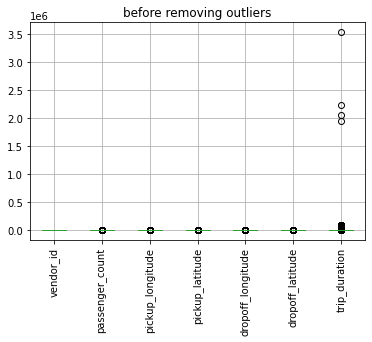

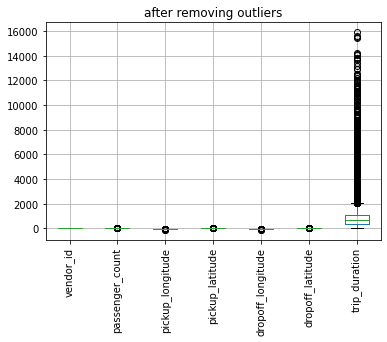

In [ ]:
taxi = remove_outliers(taxi)

In [ ]:
taxi.shape  #we have also tried removing outliers from quantile method, but in that case nearly 25% of the total values get removed.

(1397889, 11)

##Feature Engineering


###First let's add the required columns

- In adding columns there is nothing to do with id, vendor_id, passenger_count, dropoff_datetime,store_and_fwd_flag and trip_duration, so these columns are left untouch in this section.
- In **pickup_datetime:** 
  - we first separate date and time and then seperate different sections of date and time, in date, month, year and hour, we do not consider minutes and seconds as they are not that much important for prediction 
  - also we added which day of week it is and them added a column is_weekend which checks whether a column is weekend or not, as it may be possible that more traffic is observed during office days.
  - Then we added a column which shows among four shift which shift of day taxi is booked for, as different shifts may have different trip_duration for same trip.

- Using all the four columns of latitude and longitude we calculate the total_distance between initial and final position



In [ ]:
#columns before feature engineering
taxi.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

####feature engineering on pickup_datetime column:

In [ ]:
from datetime import datetime
from datetime import date

In [ ]:
def get_weekdays(dates):
  import calendar
  from datetime import date
  week_days=[]
  for i in dates:
    my_date = i.date()
    week_days.append(calendar.day_name[my_date.weekday()])
  return week_days


In [ ]:
def separate_date(date_time):
  years,months,dates=[],[],[]
  for i in date_time:
    years.append(i.year)
    months.append(i.month)
    dates.append(i.day)
  return years,months,dates
  

In [ ]:
def separate_time(date_time):
  hours,minutes,seconds=[],[],[]
  for i in date_time:
    hours.append(i.hour)
    minutes.append(i.minute)
    seconds.append(i.second)
  return hours,minutes,seconds

In [ ]:
years,months,dates=separate_date(taxi["pickup_datetime"])
taxi["pickup_year"]=years
taxi["pickup_date"]=dates
taxi["pickup_month"]=months

In [ ]:
"""
for time we will only take hours, as they are important but having minutes and seconds is not 
required as we just want an idea of time.
"""
hours,minutes,seconds=separate_time(taxi["pickup_datetime"])
taxi["pickup_hour"]=hours

In [ ]:
taxi["pickup_weekday"]=get_weekdays((list(taxi["pickup_datetime"])))

In [ ]:
def check_isweekend(x):
  if x in ['Monday','Tuesday','Wednesday','Thursday','Friday']:
    x = 0
    return x
  else:
    x = 1
    return x

In [ ]:
taxi['pickup_is_weekend'] = taxi['pickup_weekday'].apply(check_isweekend)

In [ ]:
def convert_pickup_hour(x):
  if x in [0,1,2,3,4,5,6]:
    x = 'mid_night'
    return x
  elif x in [7,8,9,10,11,12]:
    x = 'office_time'
    return x
  elif x in [13,14,15,16,17,18]:
    x = 'lunch_time'
    return x
  else:
    x = 'Evening_time'
    return x

In [ ]:
taxi['pickup_shift'] = taxi['pickup_hour'].apply(convert_pickup_hour)

In [ ]:
##Give a Pandas command to convert the categorical attribute, pickup_shift into dummy variables.
taxi['pickup_shift'].replace(to_replace=['mid_night', 'office_time','lunch_time',  'Evening_time'], value=[0,1,2,3] ,inplace=True)

####Feature Engineering to find total distance

Calculating distance from latitude and longitude using Haversine’ formula. The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes. Given by(in miles)

$$Distance = 3963.0*arccos[(sin(lat1)*sin(lat2))+cos(lat1)*cos(lat2)*cos(long1-long2)]$$

First we convert latitude and longitude in radian.

In [ ]:
import math
def convert_radian(arg):
  ''' This function convert degree to radian
  input is in degree 
  output is in radian'''

  return arg*(math.pi/180)


In [ ]:
def  haversine_formula(lat1,lat2,long1,long2):
  ''' lat1 = pickup latitude(in radian form)
  lat2 = dropoff_latitude(in radian form)
  long1 = pickup longitude(in radian form)
  long2 = dropoff longitude(in radian form)'''
  a = (np.sin(lat1)*np.sin(lat2))+(np.cos(lat1)*np.cos(lat2)*np.cos(long2-long1))
  b = np.arccos(a)
  c = 3963.0*1.609344*b # convert into KM

  return c

In [ ]:
distance = [ 'pickup_longitude','pickup_latitude', 'dropoff_longitude','dropoff_latitude']
for col in distance:
  taxi[col] = taxi[col].apply(convert_radian)

In [ ]:
taxi['total_distance'] = haversine_formula(taxi['pickup_latitude'],taxi['dropoff_latitude'],taxi['pickup_longitude'],taxi['dropoff_longitude'])

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


###Now deleting the required rows and columns:
we will drop the following columns now, using eda we will drop some columns later if required: 

- id: because it does not have any relation with trip duration
- dropoff_datetime: The column drop off time is a dependent column, as drop off time will depend on trip time, so indirectly it is also a dependent feature,
but before that we will drop those columns in which the difference between pickup and dropoff date time is not eqaul to trip duration if such columns arepresent.
- pickup_year: we will drop pickupp year as we will note that the all the records are of year 2016.
- pickup_date: we will alos drop pick_up date as trip duration is not much affected by date
- pickup_hour: as we will consider shifts for a day not separate hour
- time difference: as that column was just for checking whether the entry in dependent variable is correct or not
- also we delete some rows from passenger count where the value is 0


In [ ]:
taxi.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_year', 'pickup_date', 'pickup_month',
       'pickup_hour', 'pickup_weekday', 'pickup_is_weekend', 'pickup_shift',
       'total_distance'],
      dtype='object')

In [ ]:
taxi["time_difference"]=(taxi["dropoff_datetime"]-taxi["pickup_datetime"]).values
time_diff_seconds=((taxi["time_difference"].values).astype(int))/(10**9)
taxi["time_difference"]=time_diff_seconds
taxi[taxi["trip_duration"]!=taxi["time_difference"]]
#this means for every column the difference between pickup_time and dropoff_time= trip_duration so we can drop dropoff time

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_year,pickup_date,pickup_month,pickup_hour,pickup_weekday,pickup_is_weekend,pickup_shift,total_distance,time_difference


In [ ]:
print(taxi["pickup_year"].value_counts())
#as year is only 2016 so it is of no use

2016    1397889
Name: pickup_year, dtype: int64


In [ ]:
taxi.drop(["id","pickup_datetime","dropoff_datetime","pickup_year","pickup_date","pickup_hour","time_difference"],inplace=True,axis=1)

In [ ]:
"""
from previous analysis we note that some records have passenger count as 0,so those records are of no use so lets remove them.
"""
taxi.index=np.arange(0,taxi.shape[0])
passenger_0=np.where(taxi["passenger_count"]==0)
taxi.drop(passenger_0[0], inplace = True)
taxi.shape

(1397832, 13)

In [ ]:
taxi.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_month', 'pickup_weekday', 'pickup_is_weekend',
       'pickup_shift', 'total_distance'],
      dtype='object')

##Outliers
Before observing heat maps and performing eda let's remove some outliers

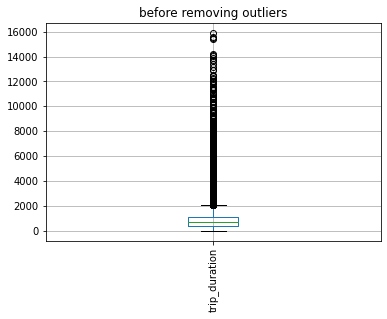

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


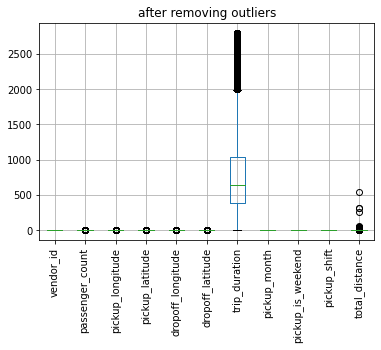

In [ ]:
taxi=remove_outliers(taxi,["trip_duration"])

In [ ]:
def convert(sec):
  min,second = divmod(sec,60)
  list1 = "%d:%02d" % (min,second)
  return int(list1.split(':')[0])

In [ ]:
taxi['trip_min'] = taxi['trip_duration'].apply(convert)

In [ ]:
taxi = taxi[(taxi['total_distance']/taxi['trip_min'])<1.5]

In [ ]:
taxi = taxi[(taxi['total_distance']/taxi['trip_min'])>0.06]

In [ ]:
taxi.drop(["trip_min"],axis=1, inplace=True)

In [ ]:
# taxi=(remove_outliers2(taxi,["total_distance"]))

In [ ]:
# taxi=remove_outliers(taxi)

In [ ]:
# taxi["speed"]=taxi["total_distance"]/taxi["trip_duration"] 

In [ ]:
taxi.shape

(1340769, 14)

##EDA:


###Analysing Distribution
Here we will draw some graphs so check the distribution of dependent variables and how other independent variables are distributed and affects the dependent variable-

In [ ]:
numeric_feature=['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude','pickup_month', 'total_distance']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


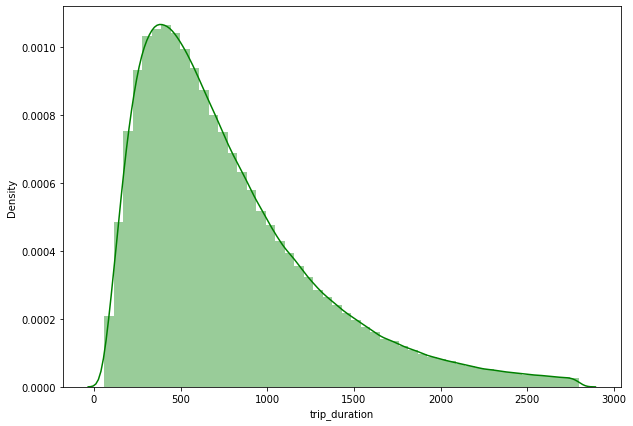

In [ ]:
# Now check the distribution of dependent variable
import seaborn as sns
fig = plt.figure(figsize=(10,7))
sns.distplot(taxi['trip_duration'], color = 'g')
#we found that the data is slightly right skewed

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


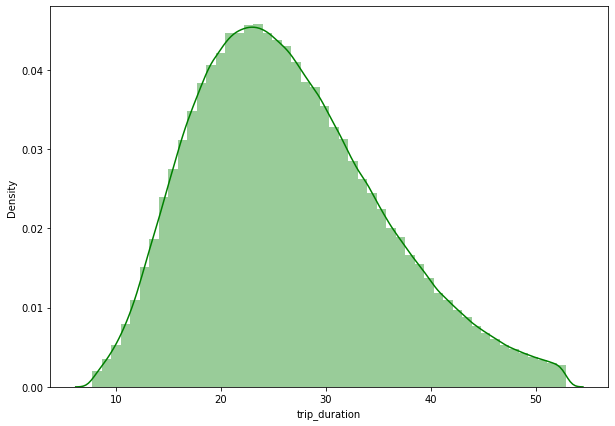

In [ ]:
fig = plt.figure(figsize=(10,7))
sns.distplot(np.sqrt(taxi['trip_duration']), color = 'g')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


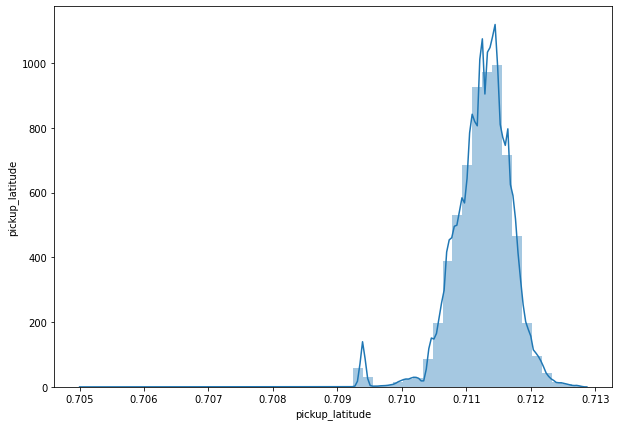

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


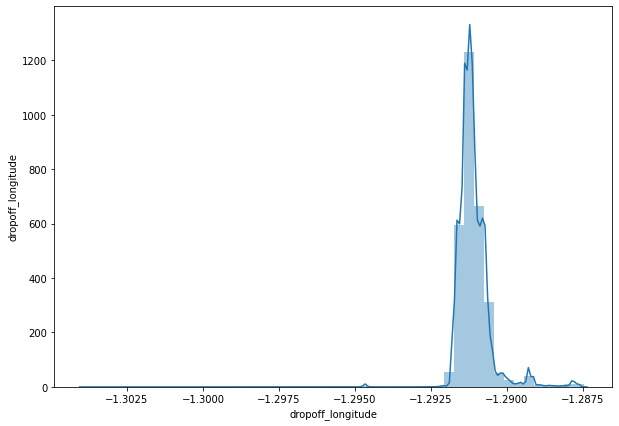

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


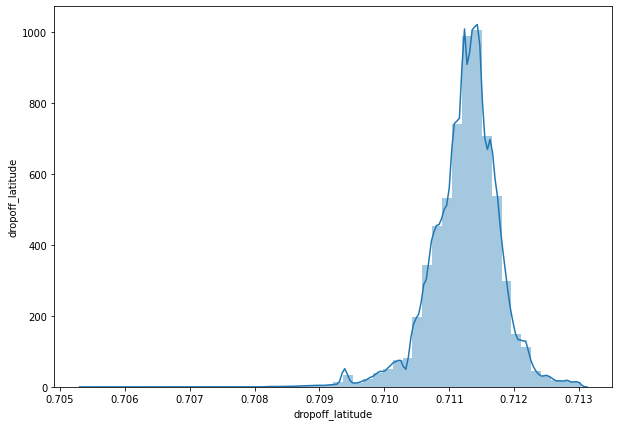

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


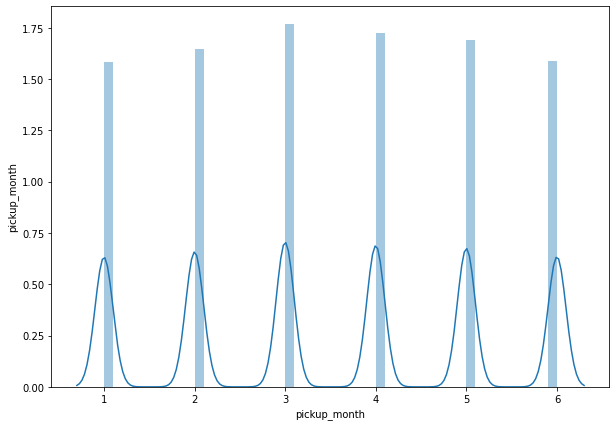

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


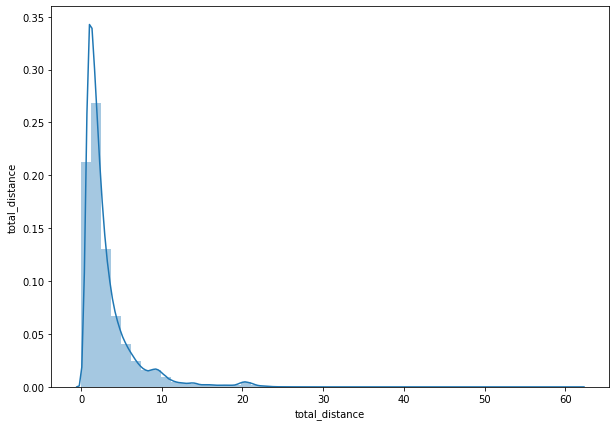

In [ ]:

for col in numeric_feature[1:]:
  if col not in ['passenger_count','trip_duration']:
    fig = plt.figure(figsize=(10,7))
    sns.distplot(taxi[col])
    plt.ylabel(col)
    plt.show()

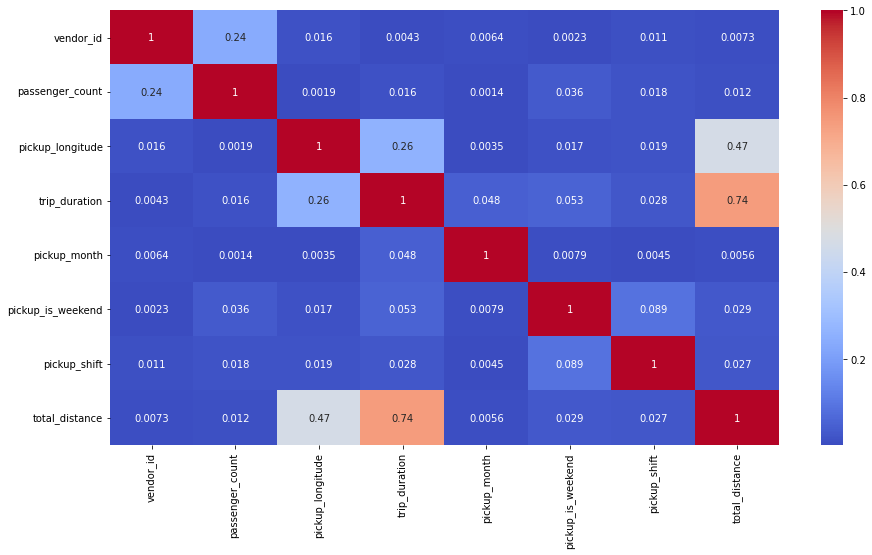

In [ ]:
#let's have a look at correlation of different attributes and remove multicollinearity
plt.figure(figsize=(15,8))
correlation = taxi.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

From here we note that there is a good correlation between trip_durationa and total distance, so we conclude that duration mainly depends on distance and not on the path or the initial and final positions, so we drop the four columns which represents geographic location of final and initial point

In [ ]:
#remove multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(x):
  vif = pd.DataFrame()
  vif['columns'] = x.columns
  vif['vif_values'] = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]

  return vif

In [ ]:
numeric_feature1 = taxi.describe().columns
numeric_feature1

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'trip_duration',
       'pickup_month', 'pickup_is_weekend', 'pickup_shift', 'total_distance',
       'trip_min'],
      dtype='object')

In [ ]:
calc_vif(taxi[[col for col in numeric_feature1 if col not in ['trip_duration']]])
#,'pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude'
#VIF measure the multicollinearity between the independent variable. We will drop the columns for which vif_values that are very high

,columns,vif_values
0,vendor_id,10.836354
1,passenger_count,3.237515
2,pickup_longitude,20.258167
3,pickup_month,5.380676
4,pickup_is_weekend,1.434409
5,pickup_shift,3.900348
6,total_distance,4.365818
7,trip_min,6.996246


vif values are very high for latitude and longitude columns, we note that pickup_longitude have a good correlation with our dependent attribute so let's drop other three

In [ ]:
taxi.drop(["pickup_latitude","dropoff_latitude","dropoff_longitude"],axis=1,inplace=True)

In [ ]:
linear_set = ['vendor_id','passenger_count','total_distance','pickup_month']

In [ ]:
taxi.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude',
       'store_and_fwd_flag', 'trip_duration', 'pickup_month', 'pickup_weekday',
       'pickup_is_weekend', 'pickup_shift', 'total_distance'],
      dtype='object')

In [ ]:
#Now we do some analysis on categorical variable
categorical_feature = list(taxi.describe(include = 'object').columns)
categorical_feature.extend(['pickup_is_weekend'])

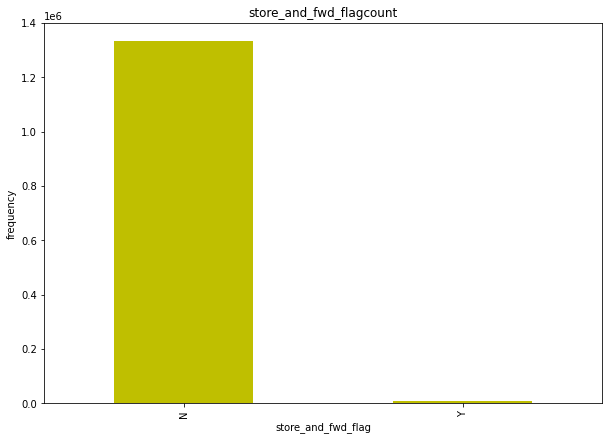

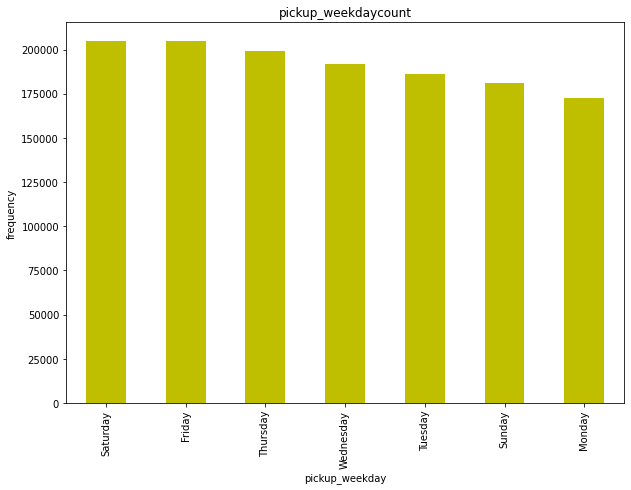

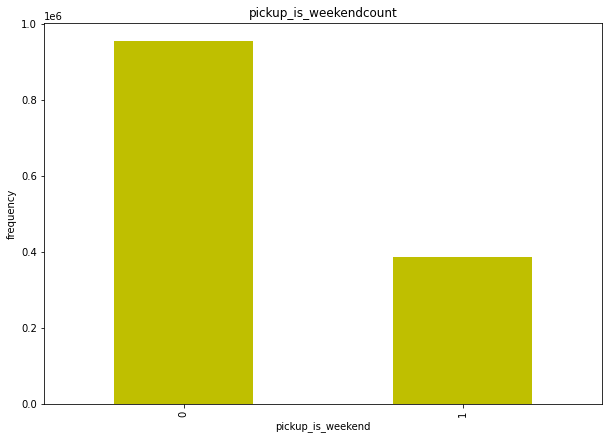

In [ ]:
#to have a look at the distribution of various categorical features
for col in categorical_feature:
  fig = plt.figure(figsize= (10,7))
  ax = fig.gca()
  counts = taxi[col].value_counts()
  counts.plot.bar(ax=ax,color='y')
  ax.set_title(col + 'count')
  ax.set_xlabel(col)
  ax.set_ylabel('frequency')

So we will drop the column pickup_weekday and pickup_hours as pickup_weekday and pickup_is_weekend is correlated to each other. Whereas pickup_hours and pickup_shift are correlated.

In [ ]:
features=["vendor_id","pickup_month"]+categorical_feature
features

['vendor_id',
 'pickup_month',
 'store_and_fwd_flag',
 'pickup_weekday',
 'pickup_is_weekend']

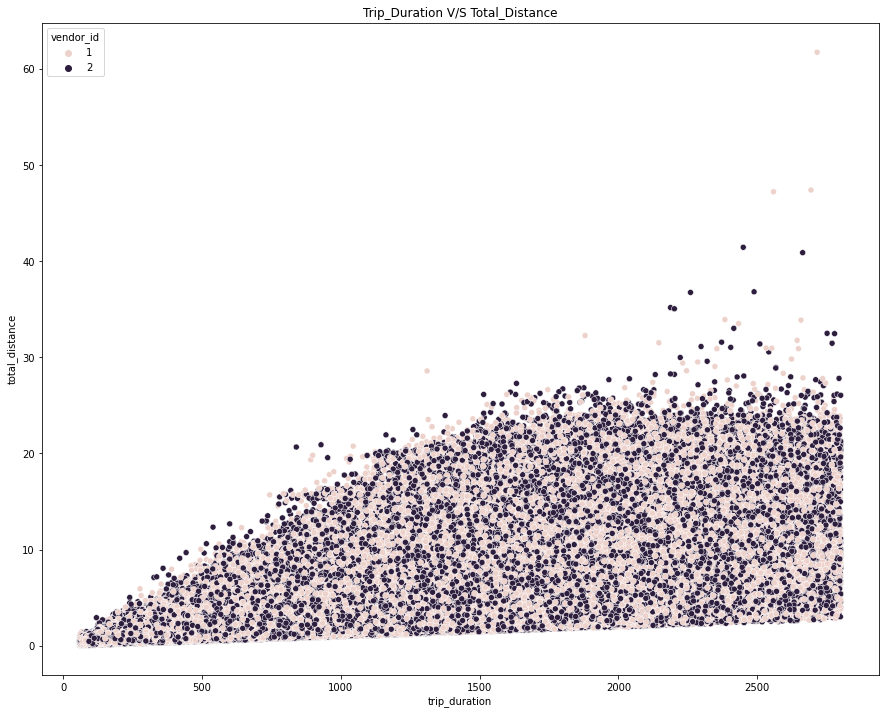

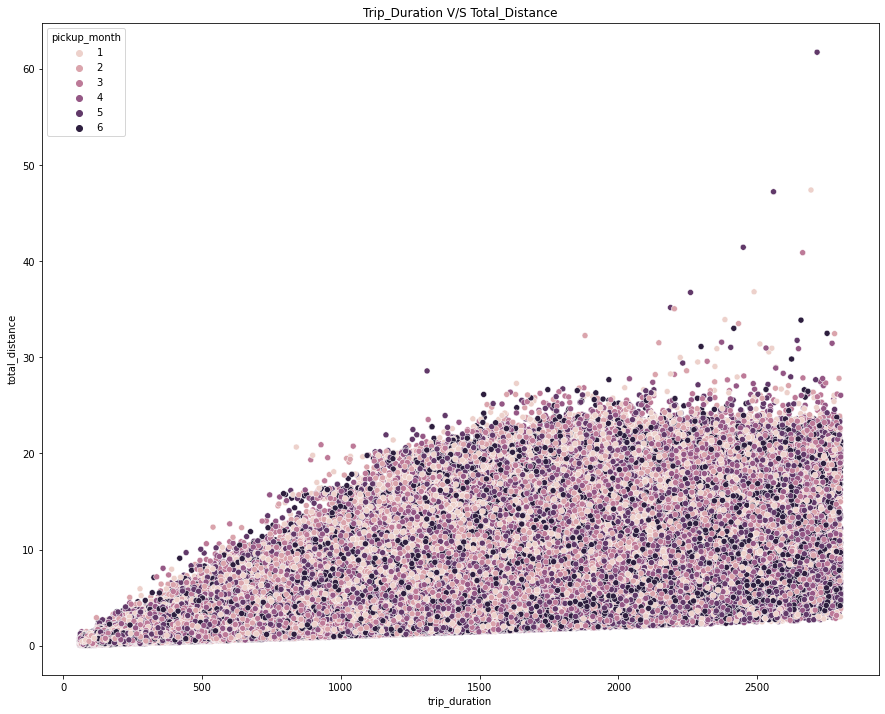

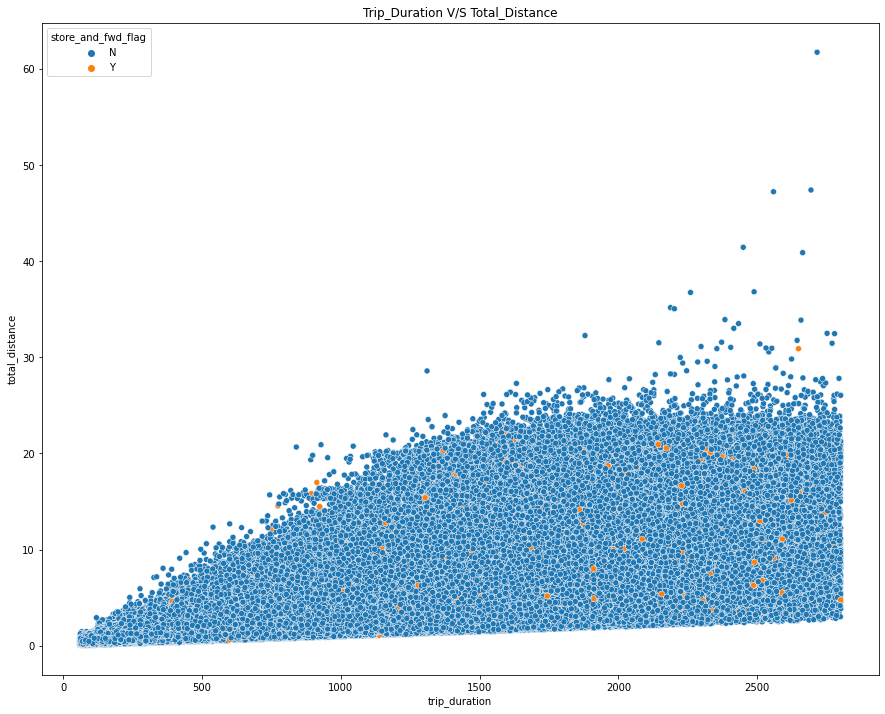

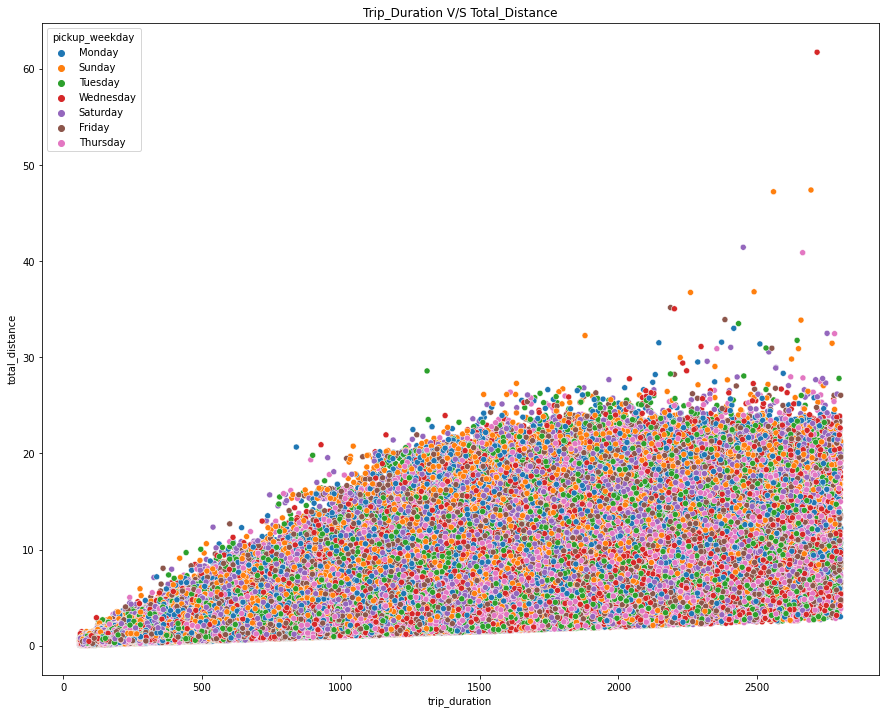

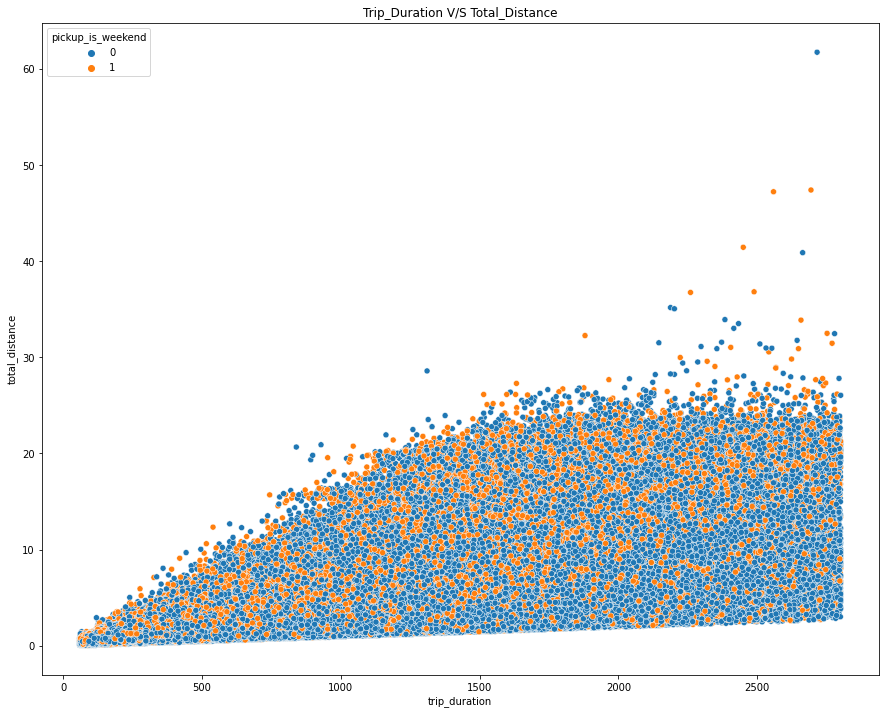

In [ ]:
#but we do not very much bother about their separate distribution what we care about is how these features affect our dependent variable
features=["vendor_id","pickup_month"]+categorical_feature
for col in features:
  plt.figure(figsize=(15,12),facecolor='white',edgecolor='orange')
  plt.title("trip_duration v/s total_distance".title())
  sns.scatterplot(x="trip_duration",y="total_distance",data=taxi,hue=col, alpha=1, legend="brief")#,y_bins=[10*i for i in range(0,20)])
  plt.show()

From above we note that:
- vendor_id: For a longer trip or for a longer path vendor_id 2 is preffered
- pickup_month: Data is not properly separated but for a better result we will do some more analysis on this column.
- store_and_fwd_flag: This is a biased column, also there is no particular separation so we will drop it.
- pickup_weekday: there is no particular separation so we will drop it.
- pickup_shift and pickup_isweekend shows some boudaries through which we can separate different colours so these attributes are important

In [ ]:
taxi.drop(['store_and_fwd_flag', 'pickup_weekday'],axis=1,inplace=True)

Conclusion:
First two features do not bother the pick_up duration much, as we note that all the colurs are mixed , and is particular boundary which tends to separate them so we drop the first two features

In [ ]:
categorical_feature=taxi.describe(include="object")

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


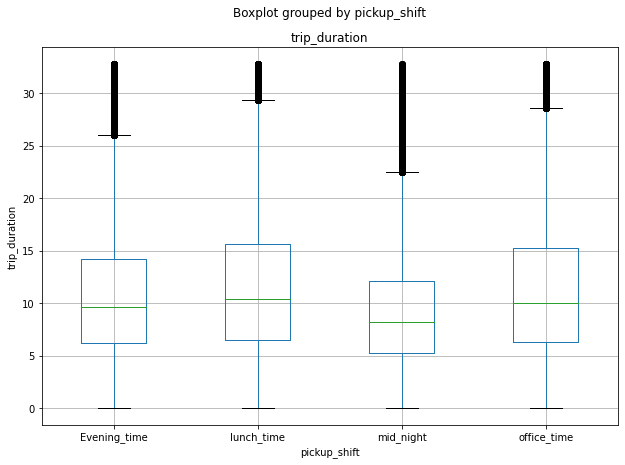

In [ ]:
for col in categorical_feature:
  fig = plt.figure(figsize=(10,7))
  ax = fig.gca()
  taxi.boxplot(column = 'trip_duration',by = col, ax=ax)
  ax.set_xlabel(col)
  ax.set_ylabel('trip_duration')
  plt.show()


In [ ]:
#we will also drop pickup month if correlation is less

taxi["pickup_month"].value_counts()
#there are total six pickup months and other six month  data is not included so what if we want to get a duration for any 
#of the next six month, so we drop this attribute also

3    236746
4    231205
5    226640
2    220939
6    212961
1    212278
Name: pickup_month, dtype: int64

In [ ]:
taxi.drop(["pickup_month"],axis=1,inplace=True)

##Supervised Learning

In [168]:
#columns left with us
taxi.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude',
       'store_and_fwd_flag', 'trip_duration', 'pickup_weekday',
       'pickup_is_weekend', 'pickup_shift', 'total_distance'],
      dtype='object')

In [169]:
(taxi.describe()).columns #here we note that all the columns have numeric data type so data is ready for prediction

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'trip_duration',
       'pickup_is_weekend', 'pickup_shift', 'total_distance'],
      dtype='object')

In [170]:
#building model

independent_var=list((abs((taxi.corr())["trip_duration"]).sort_values(ascending=False)).index)[1:]
dependent_var=["trip_duration"]
independent_var
x=taxi[independent_var]
y=taxi["trip_duration"]
#arranged independent var in proper order

#just to try
#x=x.iloc[:50000]
#y=y.iloc[:50000]

In [171]:
independent_var

['total_distance',
 'pickup_longitude',
 'pickup_is_weekend',
 'pickup_shift',
 'passenger_count',
 'vendor_id']

In [172]:
#train-test split

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test= train_test_split(x, y, test_size=0.30, random_state=324)



##Linear Regression

In [173]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [174]:
linear_model=LinearRegression()
linear_model.fit(x_train,y_train)


LinearRegression()

In [175]:
y_train_predicted=linear_model.predict(x_train)
y_test_predicted=linear_model.predict(x_test)




In [176]:
math.sqrt(mean_squared_error(y_train,y_train_predicted))

341.63333344513427

In [177]:
r2_score(y_train, y_train_predicted)

0.568787197819123

In [178]:
r2_score(y_test, y_test_predicted)

0.5687083846171164

##Decesion Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor 
  
# create a regressor object
regressor = DecisionTreeRegressor(max_depth = 15, min_impurity_decrease = 0.1, min_samples_split = 600,random_state = 0) 
  
# fit the regressor with X and Y data
regressor.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=15, min_impurity_decrease=0.1,
                      min_samples_split=600, random_state=0)

In [ ]:
regressor.score(x_train,y_train)

0.5387940508062746

In [ ]:
y_pred_dt = regressor.predict(x_test)

In [ ]:
r2 = r2_score((y_test), (y_pred_dt))
r2

0.530260903866068

In [ ]:
MSE  = mean_squared_error((y_test), (y_pred_dt))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

MSE : 19.30164289387261
RMSE : 4.39336350577466


##Gradient Boosting:

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
model=GradientBoostingRegressor()
#grid_values = {'n_estimators':[20,30], 'max_depth':[5,7]}
#model= GridSearchCV(model, param_grid = grid_values, scoring = 'r2', cv=7)

model.fit(x_train,y_train)

GradientBoostingRegressor()

In [ ]:
y_train_predicted=model.predict(x_train)
y_test_predicted=model.predict(x_test)




In [ ]:
math.sqrt(mean_squared_error(y_train,y_train_predicted))
test_rmse=math.sqrt(mean_squared_error(y_test,y_test_predicted))

In [ ]:
r2_score(y_train, y_train_predicted)

0.5953815322791086

In [ ]:
r2_score(y_test, y_test_predicted)

0.5952101669858045

In [ ]:
normalized_rmse=test_rmse/((taxi["trip_duration"].max())-(taxi["trip_duration"].min()))
normalized_rmse

0.12270183921362184

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


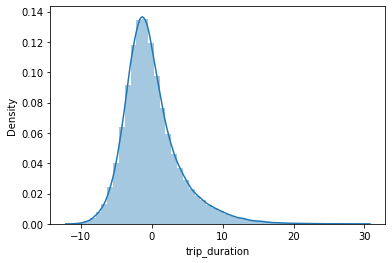

In [ ]:
#distribution plot
error=y_test-y_test_predicted
sns.distplot(error)

In [ ]:
(taxi["trip_duration"].max())

32.78333333333333

In [ ]:
33*60

1980

In [ ]:
#to check whether our model is biased or not
taxi_original[10000<taxi_original["trip_duration"]]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
531,id3307903,2,2016-02-20 04:03:06,2016-02-21 03:33:00,3,-74.008102,40.741489,-74.009956,40.714611,N,84594
1134,id1091477,2,2016-05-07 18:36:22,2016-05-08 18:32:11,1,-73.990242,40.750919,-73.976280,40.750889,N,86149
1865,id3431345,2,2016-06-07 12:58:48,2016-06-08 12:58:00,6,-73.954956,40.777649,-73.981033,40.743713,N,86352
3442,id1487069,2,2016-02-13 00:21:49,2016-02-14 00:19:05,1,-73.968590,40.799217,-73.979584,40.784714,N,86236
4172,id3674870,2,2016-03-18 11:54:20,2016-03-19 11:34:17,1,-73.989090,40.736992,-73.972336,40.751511,N,85197
...,...,...,...,...,...,...,...,...,...,...,...
1455097,id2798196,2,2016-03-20 03:51:36,2016-03-21 00:00:00,2,-73.969299,40.757301,-73.870277,40.709808,N,72504
1456458,id2055880,2,2016-02-08 19:11:31,2016-02-09 19:08:44,3,-73.973282,40.760792,-73.988518,40.764210,N,86233
1457207,id1910950,2,2016-06-08 16:29:12,2016-06-09 16:11:03,1,-73.958061,40.800869,-73.964119,40.805515,N,85311
1457752,id1215198,2,2016-02-02 11:31:10,2016-02-03 11:29:44,6,-73.972069,40.794220,-73.961014,40.806728,N,86314


In [ ]:
independent_var

['total_distance',
 'dropoff_latitude',
 'pickup_is_weekend',
 'pickup_latitude',
 'pickup_shift',
 'passenger_count',
 'pickup_longitude',
 'dropoff_longitude',
 'vendor_id']

In [ ]:
86262/60

1437.7

In [ ]:
i1

52.89162009092252

In [ ]:
i1=haversine_formula(40.760876,40.764557, -73.990479, -73.983025	)
i2=40.764557
i3=1
i4=40.760876
i5=0
i6=1
i7=-73.990479
i8=-73.983025
i9=2

In [ ]:
dep_features=pd.DataFrame([[i1,i2,i3,i4,i5,i6,i7,i8,i9]],columns=x_test.columns)
dep_features

,total_distance,dropoff_latitude,pickup_is_weekend,pickup_latitude,pickup_shift,passenger_count,pickup_longitude,dropoff_longitude,vendor_id
0,52.89162,40.764557,1,40.760876,0,1,-73.990479,-73.983025,2


In [ ]:
model.predict(dep_features)

array([13.81114717])

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
xg = XGBRegressor()
learning_rate = [0.5,0.6]
subsample = [0.8,0.9]
max_depth = [7]
grid = dict(learning_rate=learning_rate, subsample=subsample, max_depth=max_depth)
grid_search1 = GridSearchCV(xg,param_grid = grid,scoring = 'r2', cv = 3)
grid_search1.fit(x_train,y_train)

[05:49:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:52:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:55:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:57:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:58:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

GridSearchCV(cv=3, estimator=XGBRegressor(),
             param_grid={'learning_rate': [0.5, 0.6], 'max_depth': [7],
                         'subsample': [0.8, 0.9]},
             scoring='r2')

In [ ]:
print("Best: %f using %s" % (grid_search1.best_score_, grid_search1.best_params_))

Best: 0.662738 using {'learning_rate': 0.5, 'max_depth': 7, 'subsample': 0.9}


In [ ]:
y_train_predicted=grid_search1.predict(x_train)
y_test_predicted=grid_search1.predict(x_test)




In [ ]:
math.sqrt(mean_squared_error(y_train,y_train_predicted))

3.4875745134296254

In [ ]:
test_rmse=math.sqrt(mean_squared_error(y_test,y_test_predicted))

In [ ]:
r2_train=r2_score(y_train, y_train_predicted)
r2_train

0.6943383808979979

In [ ]:
r2_test=r2_score(y_test, y_test_predicted)
r2_test

0.6666563360791415

In [ ]:
v1= (1-r2_test)
v2= ((x_train.shape[0])-1) / ((x_train.shape[0])-(x_train.shape[1])-1)
adj_rsquared = (1 - (v1 * v2))
adj_rsquared

0.6666524130659224

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


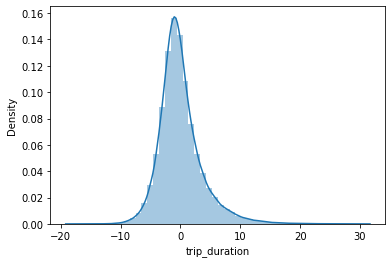

In [ ]:
error=y_test-y_test_predicted
sns.distplot(error)

In [ ]:
(taxi[["trip_duration"]]).agg(["min","max"])

,trip_duration
min,0.016667
max,32.783333


In [ ]:
(taxi["trip_duration"].min())

0.016666666666666666

In [ ]:
test_rmse/((taxi["trip_duration"].max())-(taxi["trip_duration"].min()))

0.11134798875013807

In [ ]:
from sklearn.ensemble import StackingRegressor
estimators = [ ('rg', regressor), ('lm', model) ]
reg = StackingRegressor( estimators=estimators,final_estimator=grid_search1 )


In [ ]:
reg.fit(x_train,y_train)

KeyboardInterrupt: ignored

In [ ]:
y_train_predicted=reg.predict(x_train)
y_test_predicted=reg.predict(x_test)




In [ ]:
math.sqrt(mean_squared_error(y_train,y_train_predicted))

In [ ]:
r2_train=r2_score(y_train, y_train_predicted)
r2_train

In [ ]:
r2_test=r2_score(y_test, y_test_predicted)
r2_test

In [ ]:
v1= (1-r2_test)
v2= ((x_train.shape[0])-1) / ((x_train.shape[0])-(x_train.shape[1])-1)
adj_rsquared = (1 - (v1 * v2))
adj_rsquared

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
ridge=Ridge()
params={"alpha":[1e-15,1e-10,1e-8,1e-3,1e-2,1,2,3,4,5,10,20,30]}
ridge_regressor=GridSearchCV(ridge,params,scoring="neg_mean_squared_error",cv=5)
ridge_regressor.fit(x_train,y_train)
print(ridge_regressor.best_params_)   #which lemda value is most suitable.
print(ridge_regressor.best_score_)     
#is linear regression mean  mse is -37.something which is lesser than -31._____  so ridge regression is not good in this case.

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
lasso=Lasso()
params={"alpha":[1e-15,1e-10,1e-8,1e-3,1e-2,1,2,3,4,5,10,20,30,40,45,50,55,70,90,100]}
lasso_regressor=GridSearchCV(lasso,params,scoring="neg_mean_squared_error",cv=5)
lasso_regressor.fit(x_train,y_train)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)    

In [ ]:
y_train_predicted=ridge_regressor.predict(x_train)
y_test_predicted=ridge_regressor.predict(x_test)




In [ ]:
math.sqrt(mean_squared_error(y_train,y_train_predicted))

In [ ]:
r2_score(y_train, y_train_predicted)

In [ ]:
r2_score(y_test, y_test_predicted)

In [ ]:
y_train_predicted=lasso_regressor.predict(x_train)
y_test_predicted=lasso_regressor.predict(x_test)

In [ ]:
math.sqrt(mean_squared_error(y_train,y_train_predicted))

In [ ]:
r2_test=r2_score(y_train, y_train_predicted)

In [ ]:
r2_score(y_test, y_test_predicted)

In [ ]:
x_train.shape[0]

In [ ]:
v1= (1-r2_test)
v2= ((x_train.shape[0])-1) / ((x_train.shape[0])-(x_train.shape[1])-1)
adj_rsquared = (1 - (v1 * v2))
adj_rsquared

In [ ]:
adj_rsquared